In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from scipy.integrate import trapz # trapezoidal rule to compute integral

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Import and clean data

prod_per_producer = pd.read_csv('Production_per_producer_2013_14.csv')
farm_sizes = pd.read_csv('farm_size_rainforest_sample.csv')[:-2]
prod_volume = pd.read_csv('production_volume.csv', usecols=[0,1])[1:-2]

str2float = lambda x: np.float(x.replace(',', ''))
prod_per_producer['prod'] = prod_per_producer['Production_FANEGAS'].apply(str2float)

farm_sizes['prod_area'] = farm_sizes['Area in production (ha)'].apply(str2float)

to_kg = lambda x: np.float(x.replace(',', ''))*46
prod_volume['yield_in_kg'] = prod_volume['Harvest Year 2015-2016'].apply(to_kg)
prod_volume = prod_volume[prod_volume.yield_in_kg > 0]

In [3]:
def best_kde(dat):
    """ Optimizes KDE params using cross validation and returns KDE w/best params. """
    
    data = dat[:, None]
    grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(0.1, dat.max()/50, 20),
                         'kernel' : ['tophat', 'epanechnikov', 'gaussian']},
                        cv=25)
    grid.fit(data)

    print grid.best_params_
    return grid.best_estimator_

In [4]:
def plot_kde(kde, dat, xlabel, title):
    """ Plots data and KDE curve together. """
    
    x_grid = np.linspace(dat.min(), dat.max(), 500)
    pdf = np.exp(kde.score_samples(x_grid[:, None]))

    fig, ax = plt.subplots(figsize=(14,8))
    ax.plot(x_grid, pdf, linewidth=3, alpha=0.5)
    ax.hist(dat, 40, normed=True)
    plt.xlabel(xlabel)
    plt.ylabel('Probability density')
    plt.title(title)
    plt.show()

In [10]:
def integrate(bounds, kde, dat, name):
    """ Prints estimated # of farms in costa rica with variable of interest between
        the lower and upper bounds. Estimates come from kde curve, and also from
        multiplying the number of farms in the available data. """

    lower, upper = bounds
    r = np.linspace(lower, upper, 1000)
    integral = trapz(np.exp(kde.score_samples(r.reshape(-1,1))), r )
    empirical = len(dat[dat >= lower][dat <= upper])*(26527./len(dat))
    
    print "{} range: {} to {}".format(name, lower, upper)
    print "Estimated # farms in your range (includes of bounds): {:.2f}".format(integral*26527)    
    print '# farms in your range based on multiplying available data: ', empirical

{'kernel': 'gaussian', 'bandwidth': 1.1894736842105262}


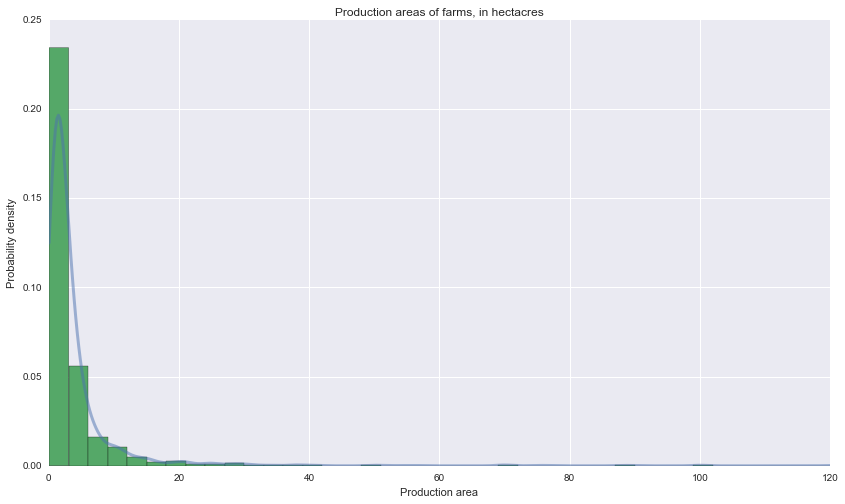

In [6]:
# Get + plot best KDE for production area
prod_area = farm_sizes['prod_area']
kde_area = best_kde(prod_area)
plot_kde(kde_area, prod_area, 
         'Production area', 
         'Production areas of farms, in hectacres')

In [11]:
integrate((5, 10), kde_area, prod_area, 'Production area')

Production area range: 5 to 10
Estimated # farms in your range (includes of bounds): 3128.53
# farms in your range based on multiplying available data:  3157.41725664


{'kernel': 'gaussian', 'bandwidth': 327.2458947368421}


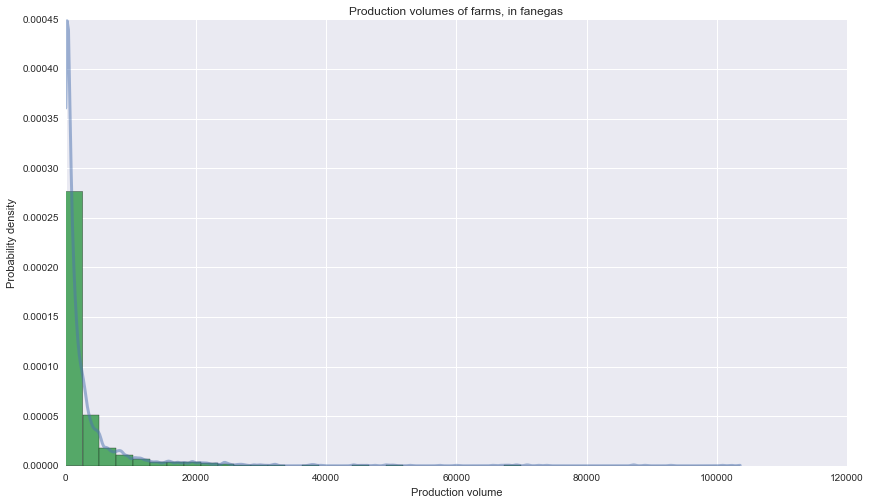

In [8]:
# Get + plot best KDE for prod volume
prod_vol = prod_volume['yield_in_kg']
kde_volume = best_kde(prod_vol)
plot_kde(kde_volume, prod_vol, 
         'Production volume', 
         'Production volumes of farms, in fanegas')

In [12]:
integrate((5000, 10000), kde_volume, prod_vol, 'Production volume')

Production volume range: 5000 to 10000
Estimated # farms in your range (includes of bounds): 2152.66
# farms in your range based on multiplying available data:  2149.756879
